This notebook does basic Bayesian regression for $\delta^{18}O_c$.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
# import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smformula
import cartopy.crs as ccrs
import pymc3 as pm

/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
coretop_path = '../data_parsed/coretops-2018-02-19.csv'
bayesreg_out_path = '../data_parsed/bayesreg_d18oc.h5'

# Read coretop data and parse

In [4]:
coretops_raw = pd.read_csv(coretop_path)

coretops_raw.sort_values('species', inplace=True)
coretops = coretops_raw.query('temp_ann > 0').copy()

This gives you an idea what the data looks like:

In [5]:
print(coretops.shape)
coretops.head()

(1280, 8)


,corename,species,latitude,longitude,d18oc,temp,temp_ann,d18osw
0,86.01,bulloides,53.40,-27.48,1.40,NaN,10.468278,0.352871
437,GIK13279-3,bulloides,18.75,-16.83,-0.13,NaN,21.023525,0.830881
989,HM58-02,bulloides,62.89,1.37,1.60,NaN,9.151978,0.294637
434,GIK13275-1,bulloides,18.75,-16.83,-0.09,NaN,21.023525,0.830881
991,HM58-03,bulloides,62.89,1.38,1.60,NaN,9.151978,0.294637


In [8]:
coretops.species.value_counts()

bulloides        358
ruberwhite       299
pachydermasin    279
ruberpink        186
pachyderma       117
sacculifer        41
Name: species, dtype: int64

# MCMC

Setup some variables to make the MCMC model specifications easier:

In [9]:
n_species = len(coretops['species'].unique())
idx_species = pd.Categorical(coretops['species']).codes

Playing with a hierarchical model setup.

Models is:
\begin{align}
\delta^{18}O_c = \alpha_i + \beta_i * T_{annual} + \delta^{18}O_sw - 0.27 + \epsilon_i \\
\end{align}

using parameters set for individual foram species ($i$):
\begin{align}
\alpha_i \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta_i \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon_i \sim \mathcal{N}(0, \tau) \\
\end{align}

and hyperparameters:
\begin{align}
\mu_\alpha \sim \mathcal{N}(0, 1) \\
\mu_\beta \sim \mathcal{N}(0, 1) \\
\sigma_\alpha \sim \mathrm{HalfCauchy}(1) \\
\sigma_\beta \sim \mathrm{HalfCauchy}(1) \\
\tau \sim \mathrm{HalfCauchy}(1)
\end{align}



## Linear model including $\delta^{18}O_{sw}$

In [10]:

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('μ_α', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('σ_α', beta=1)

    mu_b = pm.Normal('μ_β', mu=0, sd=1)
    sigma_b = pm.HalfCauchy('σ_β', beta=1)

    # Intercept and slope
    a = pm.Normal('α', mu=mu_a, sd=sigma_a, shape=n_species)
    b = pm.Normal('β', mu=mu_b, sd=sigma_b, shape=n_species)
    # Model error
    tau = pm.HalfCauchy('τ', beta=1, shape=n_species)

    # Likelihood
#     d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann']
    d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + (coretops['d18osw'] - 0.27)
    likelihood = pm.Normal('y', mu=d18oc_est, sd=tau[idx_species], 
                           observed=coretops['d18oc'])

    trace0 = pm.sample(5000, njobs=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [01:58<00:00, 46.59it/s]


### Model diagnostics

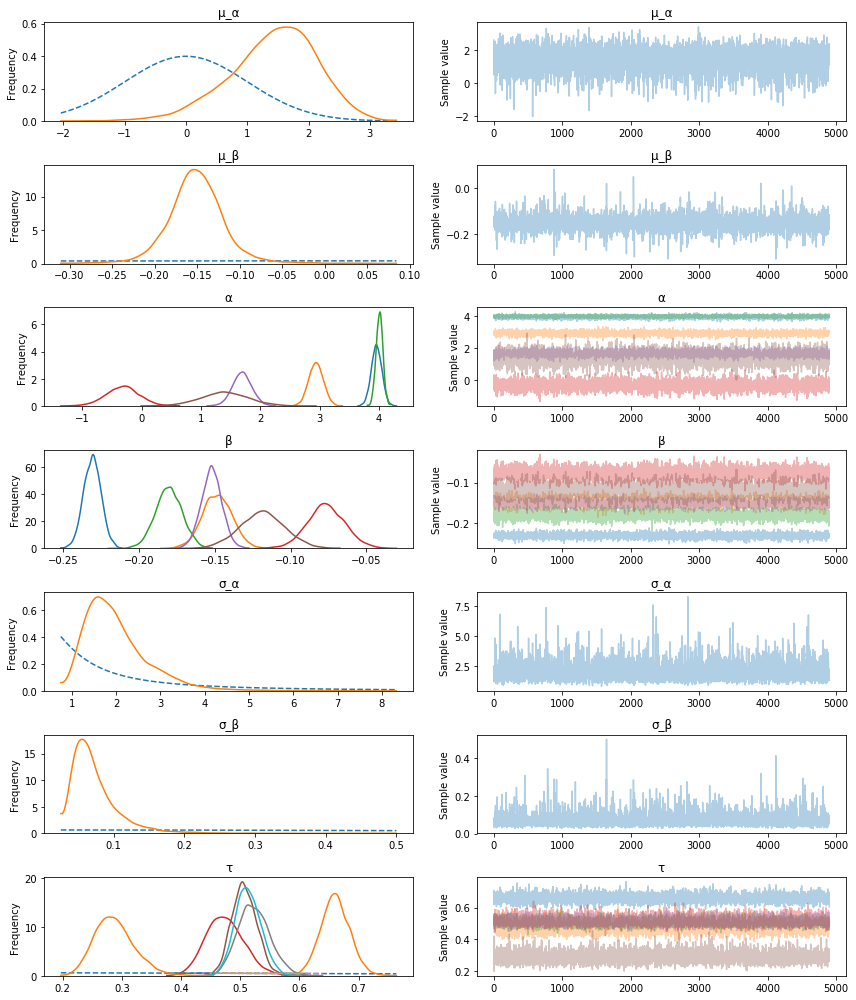

In [11]:
pm.traceplot(trace0[100:], priors=[mu_a.distribution, mu_b.distribution,
                                   None, None,
                                   sigma_a.distribution, sigma_b.distribution,
                                   tau.distribution])
plt.tight_layout()

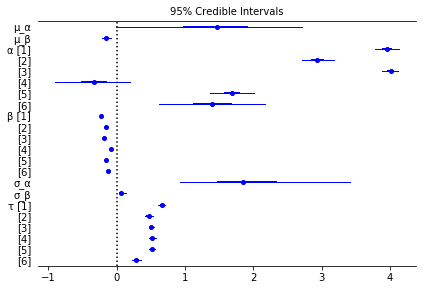

In [12]:
pm.forestplot(trace0)

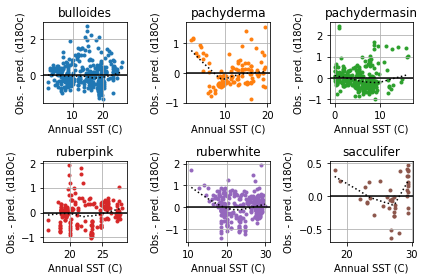

In [13]:
# Plot residuals of the median model for each spp.
# TODO(brews): This should become a function. I'm too lazy now.

for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    coretops_sub = coretops.query("species == '{}'".format(spp))
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    alpha = np.median(trace0['α'][:, spp_msk])
    beta = np.median(trace0['β'][:, spp_msk])
#     y = alpha + beta * coretops_sub['temp_ann']
    y = alpha + beta * coretops_sub['temp_ann'] + (coretops_sub['d18osw'] - 0.27)
    resids = coretops_sub['d18oc'] - y
    resids_smoothed = sm.nonparametric.lowess(resids, coretops_sub['temp_ann'], frac=0.75)
    ax.plot(resids_smoothed[:, 0], resids_smoothed[:, 1], label='LOWESS', linestyle=':', color='black')

    ax.scatter(x=coretops_sub['temp_ann'], y=resids, marker='.', label=spp, 
               color=list(matplotlib.colors.TABLEAU_COLORS.values())[i])
    ax.axhline(y=0, color='black')
    ax.set_title(spp)
    ax.set_ylabel('Obs. - pred. (d18Oc)')
    ax.set_xlabel('Annual SST (°C)')
    ax.grid(True)
plt.tight_layout()
plt.show()

### Output variable ranges

In [16]:
spp_temprange = pd.DataFrame({'species': [], 'tmin': [], 'tmax': []})
for spp, df_sub in coretops.groupby('species'):
    spp_temprange = spp_temprange.append(pd.DataFrame({'species': [spp], 
                                                       'tmin': min(df_sub['temp_ann']),
                                                       'tmax': max(df_sub['temp_ann'])}), ignore_index=True)
spp_temprange.set_index('species', inplace=True)
spp_temprange

,tmax,tmin
species,,
bulloides,26.158205,1.893083
pachyderma,19.446325,1.971666
pachydermasin,16.335115,0.037349
ruberpink,28.037800,16.599813
ruberwhite,29.975245,10.809340
sacculifer,29.495956,18.105091


In [17]:
spp_d18oswrange = pd.DataFrame({'species': [], 'd18oswmin': [], 'd18oswmax': []})
for spp, df_sub in coretops.groupby('species'):
    spp_d18oswrange = spp_d18oswrange.append(pd.DataFrame({'species': [spp], 
                                                           'd18oswmin': min(df_sub['d18osw']),
                                                           'd18oswmax': max(df_sub['d18osw'])}), ignore_index=True)
spp_d18oswrange.set_index('species', inplace=True)
spp_d18oswrange

,d18oswmax,d18oswmin
species,,
bulloides,1.640933,-0.805636
pachyderma,1.489492,-0.399891
pachydermasin,0.694273,-2.625721
ruberpink,1.167989,0.374972
ruberwhite,1.657820,-0.970013
sacculifer,1.159353,-0.079127


### Output model values to file

In [18]:
alpha = pd.DataFrame(trace0['α'])
alpha.columns = coretops['species'].unique()

beta = pd.DataFrame(trace0['β'])
beta.columns = coretops['species'].unique()

tau2 = pd.DataFrame(trace0['τ'])**2
tau2.columns = coretops['species'].unique()

# Model parameters to HDF5
alpha.to_hdf(bayesreg_out_path, key='alpha', mode='w', complevel=9, complib='blosc')
beta.to_hdf(bayesreg_out_path, key='beta', mode='r+', complevel=9, complib='blosc')
tau2.to_hdf(bayesreg_out_path, key='tau2', mode='r+', complevel=9, complib='blosc')

# Species ranges to HDF5
spp_temprange.to_hdf(bayesreg_out_path, key='spp_temprange', mode='r+', complevel=9, 
                     complib='blosc')
spp_d18oswrange.to_hdf(bayesreg_out_path, key='spp_d18oswrange', mode='r+', complevel=9, 
                       complib='blosc')